<a href="https://colab.research.google.com/github/AbhinavKumar0000/Machine_learning_practice/blob/main/crop_desease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Setup Kaggle and Download Data
import os
import zipfile
import time

#Mount Google Drive to save files permanently
from google.colab import drive
drive.mount('/content/drive')

#Installing the Kaggle library
!pip install -q kaggle

#Seting the up Kaggle API Key
from google.colab import files
if not os.path.exists("/root/.kaggle/kaggle.json"):
    print("Please upload your kaggle.json file")
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

#Downloading the dataset
zip_path = '/content/new-plant-diseases-dataset.zip'
if not os.path.exists(zip_path):
    !kaggle datasets download -d vipoooool/new-plant-diseases-dataset -p /content

#Unziping file
extract_path = '/content/dataset'
if not os.path.exists(extract_path):
    print("Unzipping dataset...")
    start_time = time.time()
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    end_time = time.time()
    print(f"Extraction completed in {end_time - start_time:.2f} seconds.")
else:
    print("Dataset already unzipped.")

#file path
base_dir = '/content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')

print(f"Train directory path set to: {train_dir}")

Mounted at /content/drive
Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.69G/2.70G [00:14<00:00, 253MB/s]
100% 2.70G/2.70G [00:14<00:00, 203MB/s]
Unzipping dataset...
✅ Extraction completed in 47.67 seconds.
Train directory path set to: /content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train


In [3]:
#necessary imports
import tensorflow as tf
from tensorflow.keras import mixed_precision
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Enable mixed precision for a ~30% speedup on Colab GPUs
mixed_precision.set_global_policy('mixed_float16')

# Optimized Configuration for Speed
IMAGE_SIZE = (128, 128)  # Smaller images
BATCH_SIZE = 64         # Larger batch size
EPOCHS = 25             # With EarlyStopping, this is a max limit
NUM_CLASSES = len(os.listdir(train_dir))

print(f"Optimized Image Size: {IMAGE_SIZE}")
print(f"Optimized Batch Size: {BATCH_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")

Optimized Image Size: (128, 128)
Optimized Batch Size: 64
Number of Classes: 38


In [4]:
print("Setting up optimized data generators for MobileNetV2...")

# Create an ImageDataGenerator for the training set with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Use the specific preprocessing function for MobileNetV2
    rotation_range=30,          # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.2,            # Apply shear transformations
    zoom_range=0.2,             # Randomly zoom in on images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Strategy for filling in newly created pixels
)

# Create an ImageDataGenerator for the validation set.
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create a generator that will read images from the training directory,
# apply the augmentations, and feed them to the model in batches.
train_generator = train_datagen.flow_from_directory(
    train_dir,                  # Path to the training data
    target_size=IMAGE_SIZE,     # Resize all images to the required input size for the model
    batch_size=BATCH_SIZE,      # Number of images to process in each batch
    class_mode='categorical'    # Since this is a multi-class classification, we use categorical labels (one-hot encoded)
)

# Create a generator for the validation data.
validation_generator = validation_datagen.flow_from_directory(
    valid_dir,                  # Path to the validation data
    target_size=IMAGE_SIZE,     # Resize all images
    batch_size=BATCH_SIZE,      # Use the same batch size
    class_mode='categorical',   # Use categorical labels
    shuffle=False               # It's important to not shuffle validation data to get consistent evaluation metrics
)

Setting up optimized data generators for MobileNetV2...
Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [5]:
# Cell 4: Define and Build the Fast MobileNetV2 Model
def build_fast_model():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=IMAGE_SIZE + (3,)
    )
    base_model.trainable = False  # Freeze the base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    # The final layer must have a float32 dtype for mixed precision
    predictions = Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Building Fast MobileNetV2 Model...")
fast_model = build_fast_model()
fast_model.summary()

Building Fast MobileNetV2 Model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,933,350 (11.19 MB)

 Trainable params: 675,366 (2.58 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# Train the Model
print("\n--- Starting Model Training ---")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

history = fast_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks
)


--- Starting Model Training ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 496s 420ms/step - accuracy: 0.6684 - loss: 1.1508 - val_accuracy: 0.8705 - val_loss: 0.3925 - learning_rate: 0.0010
Epoch 2/25
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 365s 332ms/step - accuracy: 0.8477 - loss: 0.4747 - val_accuracy: 0.9023 - val_loss: 0.2920 - learning_rate: 0.0010
Epoch 3/25
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 352s 321ms/step - accuracy: 0.8612 - loss: 0.4238 - val_accuracy: 0.9140 - val_loss: 0.2648 - learning_rate: 0.0010
Epoch 4/25
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 378s 317ms/step - accuracy: 0.8708 - loss: 0.3942 - val_accuracy: 0.9099 - val_loss: 0.2645 - learning_rate: 0.0010
Epoch 5/25
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 356s 324ms/step - accuracy: 0.8753 - loss: 0.3853 - val_accuracy: 0.9021 - val_loss: 0.3012 - learning_rate: 0.0010
Epoch 6/25
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 350s 318ms/step - accuracy: 0.8792 - loss: 0.3766 - val_accuracy: 0.9082 - val_loss: 0.2749 - learning_rate: 0.0010
Epoch 7/25
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 351s 319ms

In [7]:
# Cell 6: Evaluation and Visualization Functions
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss'); plt.legend()
    plt.savefig(f"/content/drive/My Drive/{model_name}_training_curves.png")
    plt.show()

def evaluate_model(model, model_name):
    print(f"\n--- Evaluating {model_name} ---")
    predictions = model.predict(validation_generator, steps=len(validation_generator), verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = validation_generator.classes
    class_labels = list(validation_generator.class_indices.keys())

    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print("\nClassification Report:\n", report)
    with open(f"/content/drive/My Drive/{model_name}_report.txt", "w") as f:
        f.write(report)

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(20, 18))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
    plt.savefig(f"/content/drive/My Drive/{model_name}_confusion_matrix.png")
    plt.show()

In [11]:
# Generate Classification Report
from sklearn.metrics import classification_report
import numpy as np

print("--- Generating Classification Report ---")

# Ensure the generator is reset before prediction
validation_generator.reset()

# Get predictions from your trained model
predictions = fast_model.predict(validation_generator, steps=len(validation_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Create and print the report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

--- Generating Classification Report ---
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.90      0.92      0.91       504
                                 Apple___Black_rot       0.94      0.99      0.97       497
                          Apple___Cedar_apple_rust       0.99      0.98      0.98       440
                                   Apple___healthy       0.94      0.97      0.95       502
                               Blueberry___healthy       0.97      0.95      0.96       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.96      0.98       421
                 Cherry_(including_sour)___healthy       0.94      1.00      0.97       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.91      0.92       410
                       Corn_(maize)___Common_rust_       0.98      1.00      0.99      

--- Plotting Confusion Matrix ---


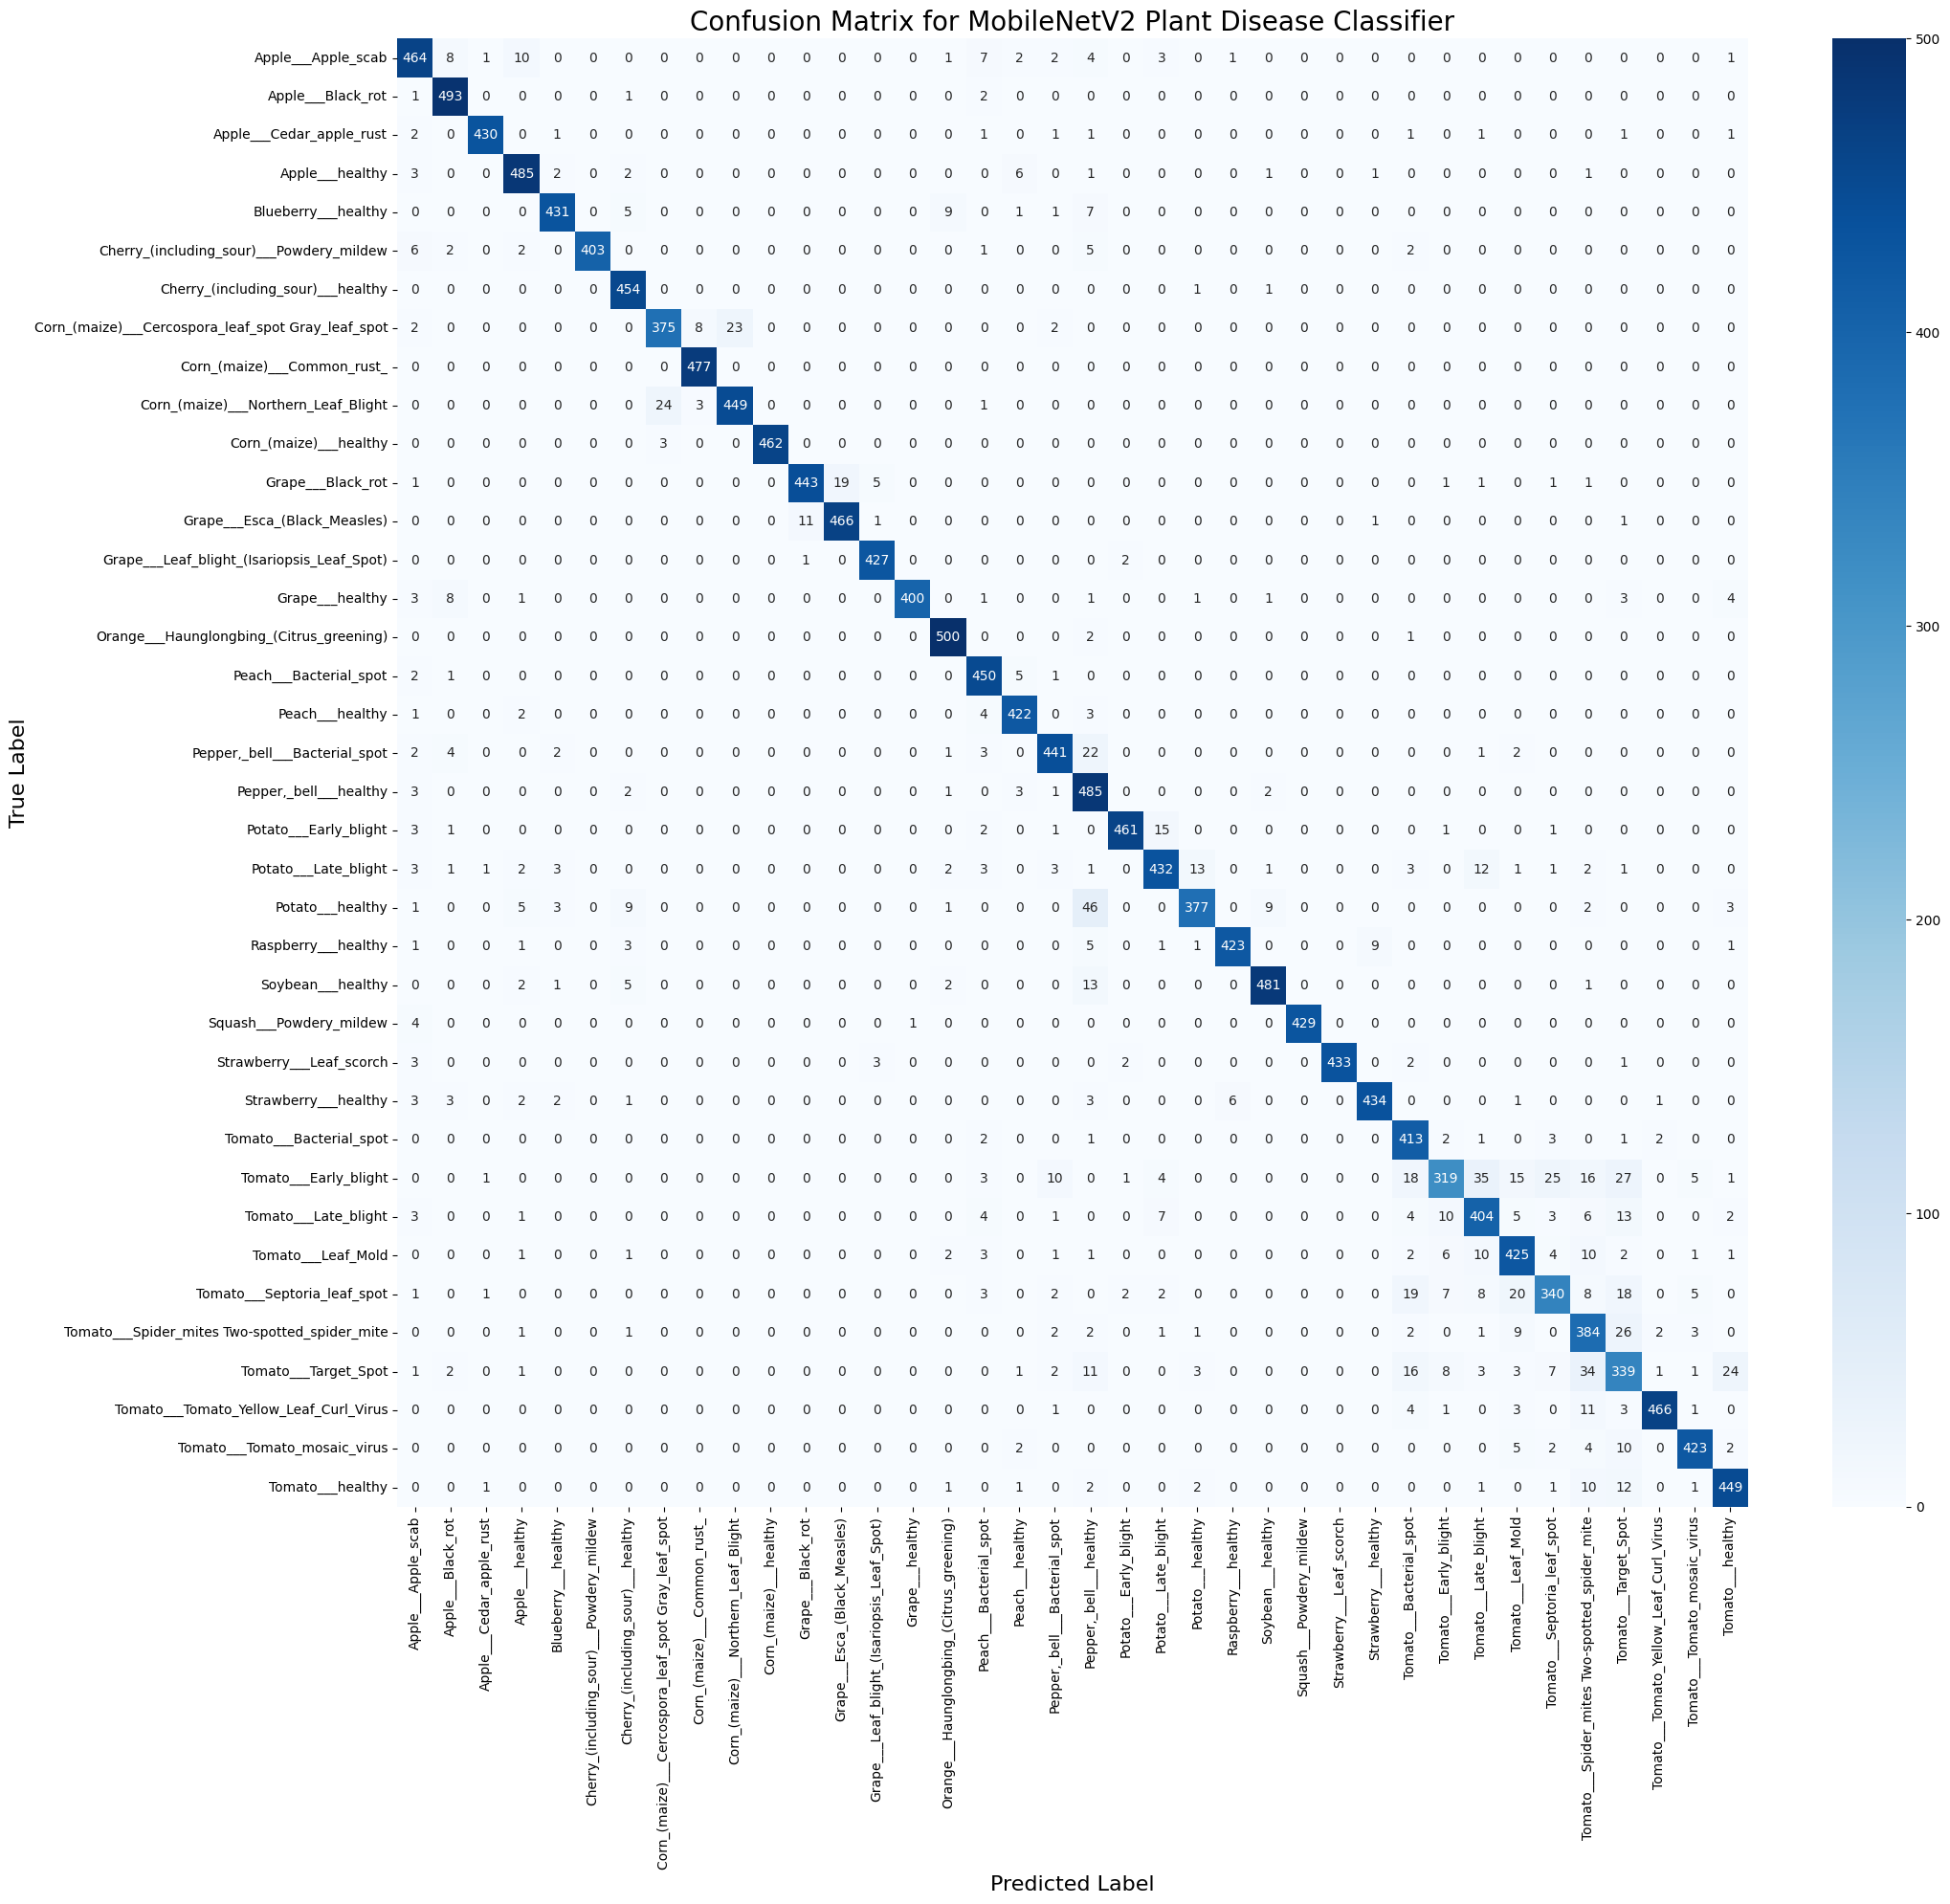

In [12]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Plotting Confusion Matrix ---")

# Create the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot it using seaborn
plt.figure(figsize=(22, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for MobileNetV2 Plant Disease Classifier', fontsize=20)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

--- Plotting Training and Validation Curves ---


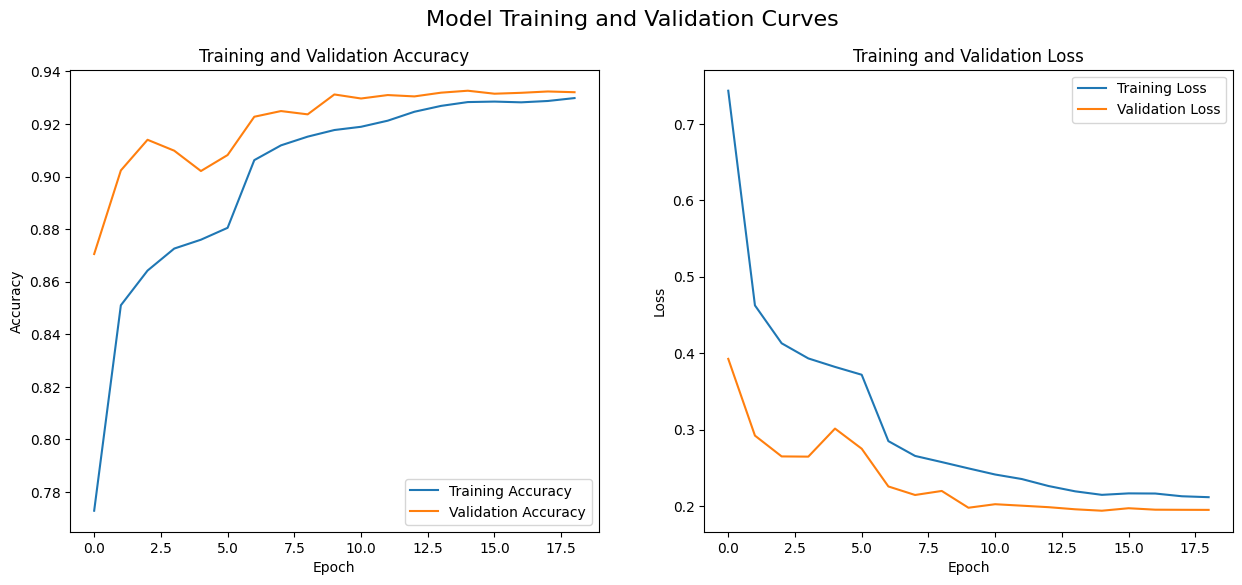

In [13]:
# Cell: Plot Training & Validation Curves
import matplotlib.pyplot as plt

print("--- Plotting Training and Validation Curves ---")

# Access the training history from your 'history' object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.suptitle('Model Training and Validation Curves', fontsize=16)
plt.show()